# <a href = 'https://www.kaggle.com/c/mercari-price-suggestion-challenge'>Mercari Price Suggestion Challenge</a>

- train_id : 데이터 id
- name : 제품명
- item_condition_id : 판매자가 제공하는 제품 상태 
- category_name : 카테고리 이름 
- brand_name : 브랜드 이름
- price : 제품 가격, 예측을 위한 타깃 속성
- shipping : 배송비 무료 여부, 1이면 무료(판매자가 지불), 0이면 유료(구매자가 지불)
- item_description : 제품에 대한 설명

### Data Preprocessing

In [1]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('data/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [2]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


brand_name column의 경우 많은 양의 Null을 가지고 있다. 전체 1482535건 중 849853건만 Not Null이다. <br>
brand_name은 가격에 영향을 미치는 중요한 요인으로 판단되지만, 많은 데이터가 Null이다. <br> 
Null 데이터는 이후 적절한 문자열로 치환이 필요하다. 

회귀에서 target 값의 정규 분포도는 매우 중요하므로 target 값인 price column의 데이터 분포도를 확인해야 한다. <br>
왜곡돼 있을 경우 보통 log를 씌워 변환하면 대부분 정규 분포의 형태를 가지게 된다. <br>
먼저 price column의 데이터 값 분포도를 확인한다.

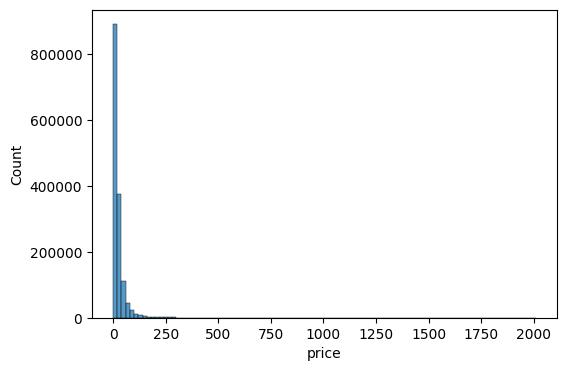

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize = (6, 4))
sns.histplot(y_train_df, bins = 100)
plt.show()

price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포되어 있다. price column을 log 값으로 변환한 뒤 분포도를 다시 살펴보아야 한다. 

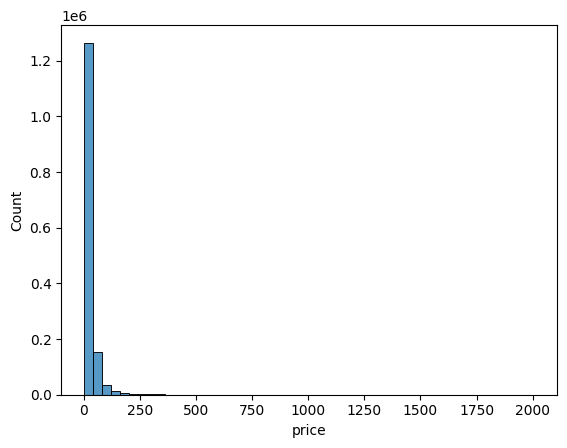

In [4]:
import numpy as np

y_tarin_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins = 50)
plt.show()

log 값으로 변환하면 price 값이 비교적 정규 분포에 가까운 데이터를 이루게 된다. <br>
데이터 세트의 price column을 원래 값에서 log로 변환된 값으로 변경한다. 

In [5]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

shipping과 item_condition_id 값의 유형은 다음과 같다. 

In [6]:
print('shipping 값 유형 :', mercari_df['shipping'].value_counts())
print('\n')
print('item_condition_id 값 유형 :', mercari_df['item_condition_id'].value_counts())

shipping 값 유형 : shipping
0    819435
1    663100
Name: count, dtype: int64


item_condition_id 값 유형 : item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


shipping column은 배송비 유무이며, 값이 비교적 균일하다. <br> 
item_condition_id는 판매자가 제공하는 제품 상태로 각 값이 의미하는 바는 kaggle에 기재되어 있지 않아 알 수 없지만 1, 2, 3 값이 주를 이루고 있다. <br>

item_description column은 Null 값이 별로 없지만, 별도 설명이 없는 경우 'No discription yet' 값으로 표시되어 있다. 

In [7]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

'No discription yet'의 경우 Null과 마찬가지로 의미 없는 속성값이기 때문에 적절한 값으로 변경이 필요하다. 

category_name은 '/'으로 분리된 카고리를 하나의 문자열로 나타내고 있다. <br>
category_name colum을 '/'를 기준으로 대, 중, 소분류를 효과적으로 분리해내기 위해 별도의 split_cat() 함수를 생성하고 이를 apply lambda식에 적용한다. <br>
category_name은 약 6300개의 Null 값을 가지고 있으므로 이를 분리해야한다. <br>
만일 category_name이 Null일 경우 split() 함수에 error가 발생하므로 이 error를 except catch하여 대, 중, 소 분류 모두 'Other Null' 값을 부여한다. <br>
pandas의 apply lambda로 반환되는 데이터 세트가 리스트를 요소로 가지고 있는데, 이를 다시 cat_dae, cat_jung, cat_so의 df column으로 분리해야하는 것이다. #

In [8]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성 
# 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return['Other_Null', 'Other_Null', 'Other_Null']

# 위 split_cat()을 apply lambda에서 호출해 대, 중, 소 column을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
    zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중, 소분류는 값의 유형이 많으므로 갯수만 print
print('대분류 유형 :', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 : cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


brand_name은 price 값 결정에 영향을 많이 줄 것으로 판단되지만, Null 값이 매우 많다. <br>
이 Null 값을 다른 값으로 변경하는 것은 적절하지 않을 것으로 판단되므로 'Other_Null'로 변경한다. 

In [9]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value = 'Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value = 'Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value = 'Other_Null')

# 각 column별로 Null 값 건수 확인, 모두 0이 나와야 한다. 
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

### Feature Incoding과 Feature Vectorization

Mercari Price Suggestion에 이용되는 데이터 세트는 문자열 column이 많다. 이 문자열 column 중 레이블 또는 원-핫 인코딩을 수행하거나 feature vectorization로 변환할 column을 선별해야 한다. <br>
먼저 feature를 어떤 방식으로 변환할지 검토 후 추후 일괄적으로 전체 속성 변환 작업을 적용한다. <br>
Mercari Price Suggestion은 price 값을 예측해야하므로 회귀 모델을 기반으로 한다. <br>
선형 회귀와 회귀 트리 모델 모두를 적용할 것이며, 선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로 인코딩할 feature는 모두 원-핫 인코딩을 적용한다. 

In [11]:
print('brand name의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 :', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수 : 4810
brand name sample 5건 : brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64
